## Introduction to machine learning with TensorFlow

This notebook is intended to be run in a local Python environment with access to the TensorFlow package.

In [19]:
from modules.tensorflow_functions import *
from ucimlrepo import fetch_ucirepo

Read in data - we are using the abalone mollusc dataset from the UCI ML dataset repository:

In [20]:
abalones = fetch_ucirepo(id=1)

abalones_df = abalones.data.original

abalones_df.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Using the UCI ML repo package, the dataset comes with the variables already split into features and labels:

In [21]:
# Features:
abalones_x = abalones.data.features

# Labels:
abalones_y = abalones.data.targets

print("The features of this dataset are:\n")
for col in abalones_x.columns: print(col)

print("\nThe labels of this dataset are:\n")
for col in abalones_y.columns: print(col)

The features of this dataset are:

Sex
Length
Diameter
Height
Whole_weight
Shucked_weight
Viscera_weight
Shell_weight

The labels of this dataset are:

Rings


The machine learning task is to use some combination of the sex, length, diameter, height and weights of an abalone mollusc to predict its age. Age is approximated by the number of shell rings plus 1.5. We will define the age variable below:

In [22]:
abalones_df["Age"] = abalones_df["Rings"] + 1.5

abalones_df.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5


We can see our feature set includes the variable `Sex`, which is a categorical variable. We will recode this into dummy variables:

In [23]:
encoded_sex = pd.get_dummies(abalones_df["Sex"], prefix = "Sex", dtype = int)

abalones_df = pd.concat([abalones_df, encoded_sex], axis = 1)

abalones_df.head(5)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age,Sex_F,Sex_I,Sex_M
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,16.5,0,0,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5,0,0,1
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.5,1,0,0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,11.5,0,0,1
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,8.5,0,1,0


### Single feature models

We will use functions defined in [tensorflow_functions.py](modules/tensorflow_functions.py) to build and train a linear regression model on the abalone DataFrame.

The machine learning model will depend on three hyperparameters:

- [Learning rate](https://developers.google.com/machine-learning/glossary/#learning-rate)
- [Epochs](https://developers.google.com/machine-learning/glossary/#epoch)
- [Batch size](https://developers.google.com/machine-learning/glossary/#batch_size)

It will also depend on the feature we select to predict the label, `Age`. We can first show a correlation matrix to guide our selection of feature:

In [24]:
abalones_df.corr(numeric_only=True)

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age,Sex_F,Sex_I,Sex_M
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720,0.556720,0.309666,-0.551465,0.236543
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660,0.574660,0.318626,-0.564315,0.240376
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467,0.557467,0.298421,-0.518552,0.215459
Whole_weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390,0.540390,0.299741,-0.557592,0.252038
Shucked_weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884,0.420884,0.263991,-0.521842,0.251793
Viscera_weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819,0.503819,0.308444,-0.556081,0.242194
Shell_weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574,0.627574,0.306319,-0.546953,0.235391
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000,1.000000,0.250279,-0.436063,0.181831
Age,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000,1.000000,0.250279,-0.436063,0.181831
Sex_F,0.309666,0.318626,0.298421,0.299741,0.263991,0.308444,0.306319,0.250279,0.250279,1.000000,-0.464298,-0.512528


`Shell_weight` is the feature that is most strongly correlated with our label, `Age`, so we will use it to train the model.

Epoch 1/30


42/42 [==============================] - 0s 906us/step - loss: 126.8885 - root_mean_squared_error: 11.2645
Epoch 2/30
42/42 [==============================] - 0s 875us/step - loss: 115.4319 - root_mean_squared_error: 10.7439
Epoch 3/30
42/42 [==============================] - 0s 854us/step - loss: 104.9199 - root_mean_squared_error: 10.2430
Epoch 4/30
42/42 [==============================] - 0s 831us/step - loss: 94.9178 - root_mean_squared_error: 9.7426
Epoch 5/30
42/42 [==============================] - 0s 876us/step - loss: 85.4947 - root_mean_squared_error: 9.2463
Epoch 6/30
42/42 [==============================] - 0s 860us/step - loss: 76.5953 - root_mean_squared_error: 8.7519
Epoch 7/30
42/42 [==============================] - 0s 857us/step - loss: 68.2186 - root_mean_squared_error: 8.2595
Epoch 8/30
42/42 [==============================] - 0s 826us/step - loss: 60.4039 - root_mean_squared_error: 7.7720
Epoch 9/30
42/42 [==============================] - 0s 803us/step - loss: 53.

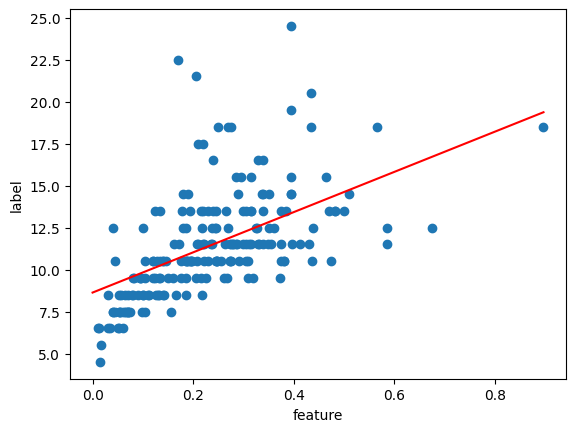

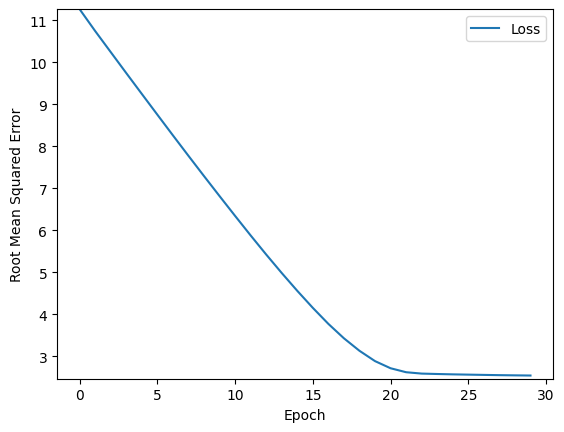

In [25]:
# Define hyperparameters
model_learning_rate = 0.01
model_epochs = 30
model_batch_size = 100

# Set label and features
model_label = "Age"
model_feature = "Shell_weight"

# Build model
base_model = build_lr_model(learning_rate = model_learning_rate)

# Train model
weight, bias, epochs, rmse = train_model(
    model = base_model,
    df = abalones_df,
    feature = model_feature,
    label = model_label,
    epochs = model_epochs,
    batch_size = model_batch_size
)

# Plot the model
plot_the_model(
    df = abalones_df,
    trained_weight = weight,
    trained_bias = bias,
    feature = model_feature,
    label = model_label
)
plot_the_loss_curve(epochs, rmse)

We can see that with the given hyperparmaters and feature, the loss function converges to a RMSE of approximately 2.5. Now that we have trained the model, we can use it to predict the age of an abalone mollusc given its shell weight.

In [26]:
predict_from_random(base_model, abalones_df, "Shell_weight", 10)

,Feature data,Predicted label
0,0.204569,11.076443
1,0.198346,11.001987
2,0.131440,10.201375
3,0.378181,13.153915
4,0.227933,11.356029
5,0.178303,10.762150
6,0.305240,12.281096
7,0.299168,12.208433
8,0.316983,12.421602
9,0.367546,13.026653
